In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import platform
import sys
import os
import sklearn 
import cv2
import json
from glob import glob

print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

- os: Windows-10-10.0.19041-SP0
- python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.3.0
- numpy: 1.19.1
- sklearn: 1.0.2
- pytorch: 1.7.0
- opencv: 4.5.5


In [2]:
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.7.0 (NVIDIA GeForce GTX 1060 6GB)


In [3]:
from shutil import copyfile
from sklearn.model_selection import StratifiedKFold

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

# Hyperparameters

In [4]:
TRAIN_PATH = 'C:/git/jonie_github/VISION/_data/train/'
BATCH_SIZE = 8
EPOCHS = 100
USE_FOLD = False
SEED = 42
NUM_FOLD = 5

# image resize
IMG_SIZE = 512

# data load

In [5]:
train_csv = sorted(glob(TRAIN_PATH +'*/*.csv'))
train_jpg = sorted(glob(TRAIN_PATH +'*/?????.jpg'))
train_json = sorted(glob(TRAIN_PATH +'*/*.json'))

test_csv = sorted(glob(TRAIN_PATH +'*/*.csv'))
test_jpg = sorted(glob(TRAIN_PATH +'*/*.jpg'))
test_json = sorted(glob(TRAIN_PATH +'*/*.json'))

In [6]:
crop_dict = {1:'딸기', 
             2:'토마토',
             3:'파프리카',
             4:'오이', 
             5:'고추',
             6: '시설포도'}

area_dict = {1:'열매',
             2:'꽃',
             3:'잎',
             4:'가지',
             5:'줄기',
             6:'뿌리',
             7:'해충'}

task_dict = {0:'정상',
             1:'병해',
             2:'생리장애',
             3:'보호제처리반응'}

disease_dict = {'00' : '정상',
                
                # 병해 a
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                
                # 생리장애 b
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                
                # 보호제 처리반응 c
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

            # 시설 과채류
grow_dict = {11:'유묘기',
             12:'생장기',
             13:'착화/과실기',
             
             # 시설 과수류 (포도)
             21:'발아기',
             22:'개화기',
             23:'신초생장기',
             24:'과실성숙기',
             25:'수확기',
             26:'휴면기'}

risk_dict = {0:'정상',
             1:'초기',
             2:'중기',
             3:'말기'}

# 2. image load

In [7]:
def img_load(path):
    img = cv2.imread(path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:26<00:00, 214.66it/s]


In [8]:
crops = []
areas = []
diseases = []
risks = []
labels = []

parts=[]
objects = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        
        crop = sample['annotations']['crop']
        area = sample['annotations']['area']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"        
        
        crops.append(crop)
        areas.append(area)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
        r = sample['annotations']['bbox'][0]
        temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
        objects.append(temp)    
        
        p = []
        
        for part in sample['annotations']['part']:
            p.append({
                'bbox': [
                    int(part['x']), int(part['y']), int(part['w']), int(part['h'])
                ],
                'id': part['id']
            })
        parts.append(p)

In [9]:
img_name = [x.split('\\')[-1].replace('.jpg','') for x in train_jpg]
img_w = [x.shape[1] for x in imgs]
img_h = [x.shape[0] for x in imgs]

In [10]:
# df_resize = df.copy()

# df_resize.x = df.x.apply(lambda x: x * IMG_SIZE) //df_resize.img_w
# df_resize.y = df.y.apply(lambda x: x * IMG_SIZE)//df_resize.img_h
# df_resize.w = df.w.apply(lambda x: x * IMG_SIZE)//df_resize.img_w
# df_resize.h = df.h.apply(lambda x: x * IMG_SIZE)//df_resize.img_h
# df_resize.xc = df.xc.apply(lambda x: x * IMG_SIZE)//df_resize.img_w
# df_resize.yc =  df.yc.apply(lambda x : x * IMG_SIZE)//df_resize.img_h
# df_resize.img_w = df.img_w.apply(lambda x: x * IMG_SIZE)//df_resize.img_w
# df_resize.img_h = df.img_h.apply(lambda x: x * IMG_SIZE)//df_resize.img_h
# df_resize

In [11]:
df = pd.DataFrame({'image':img_name, 'img_w':img_w, 'img_h':img_h, 'crops':crops,'areas':areas,'diseases':diseases,'risks':risks, 'bbox':objects, 'labels':labels})
df['crop_area'] = df.crops.astype(str) + '_' + df.areas.astype(str)
df['disease_risk'] = df.diseases.astype(str) + '_' + df.risks.astype(str)

df['x'] = df.bbox.apply(lambda x: x[0]* IMG_SIZE) //df.img_w
df['y'] = df.bbox.apply(lambda y: y[1]* IMG_SIZE) //df.img_h
df['w'] = df.bbox.apply(lambda w: w[2]* IMG_SIZE) //df.img_w
df['h'] = df.bbox.apply(lambda h: h[3]* IMG_SIZE) //df.img_h
df['xc'] = df.x + df.w.apply(lambda w: w//2)
df['yc'] = df.y + df.w.apply(lambda h: h//2)

df_resize = df[['image','crops','areas','diseases','risks','crop_area','disease_risk','xc','yc','w','h']]
df_resize

,image,crops,areas,diseases,risks,crop_area,disease_risk,xc,yc,w,h
0,10027,3,3,b7,1,3_3,b7_1,228,272,220,237
1,10037,3,5,00,0,3_5,00_0,253,34,64,315
2,10043,3,1,00,0,3_1,00_0,254,297,362,271
3,10045,3,3,00,0,3_3,00_0,284,302,229,263
4,10063,3,1,00,0,3_1,00_0,246,336,380,283
...,...,...,...,...,...,...,...,...,...,...,...
5762,67640,3,5,00,0,3_5,00_0,174,106,213,370
5763,67644,1,3,00,0,1_3,00_0,300,224,420,488
5764,67647,2,3,a5,2,2_3,a5_2,279,336,241,174
5765,67649,1,3,00,0,1_3,00_0,347,181,293,239


# image resize & flip

In [ ]:
# # resize 이미지 저장
# # 대부분 512크기가 많아서 512로 리사이징
# resize_dir = []
# for i, img_dir in (enumerate(tqdm(train_jpg))):
#     img = cv2.resize(imgs[i], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)# INTER_CUBIC , INTER_AREA
#     img_dir = img_dir.replace('.jpg','_resize.jpg')
#     resize_dir.append(img_dir)
#     cv2.imwrite(img_dir, img)
    
# # filp 이미지 생성
# for img_dir in tqdm(resize_dir):
#     img = cv2.imread(img_dir)
#     for flip in range(2):
#         flip_dir = img_dir.replace('_resize.jpg', f'_flip{flip}.jpg')
#         cv2.imwrite(flip_dir, cv2.flip(img, flip))

In [12]:
# 좌표 변경
df_flip0 = df_resize.copy()
df_flip0.yc = df_resize.yc.apply(lambda x: IMG_SIZE - x)
df_flip0.image = df_flip0.image + '_flip0'

df_flip1 = df_resize.copy()
df_flip1.xc = df_resize.xc.apply(lambda x: IMG_SIZE - x)
df_flip1.image = df_flip1.image + '_flip1'

df_resize.image = df.image + '_resize'

# 좌표 확인

In [20]:
# print(f'df_resize.xc :{np.any(df_resize.xc>IMG_SIZE)}')
# print(f'df_resize.yc :{np.any(df_resize.yc>IMG_SIZE)}')
# print(f'df_resize.w :{np.any(df_resize.w>IMG_SIZE)}')
# print(f'df_resize.h :{np.any(df_resize.h>IMG_SIZE)}')

# print(f'df_flip0.xc :{np.any(df_flip0.xc>IMG_SIZE)}')
# print(f'df_flip0.yc :{np.any(df_flip0.yc>IMG_SIZE)}')
# print(f'df_flip0.w :{np.any(df_flip0.w>IMG_SIZE)}')
# print(f'df_flip0.h :{np.any(df_flip0.h>IMG_SIZE)}')

# print(f'df_flip1.xc :{np.any(df_flip1.xc>IMG_SIZE)}')
# print(f'df_flip1.yc :{np.any(df_flip1.yc>IMG_SIZE)}')
# print(f'df_flip1.w :{np.any(df_flip1.w>IMG_SIZE)}')
# print(f'df_flip1.h :{np.any(df_flip1.h>IMG_SIZE)}')


# print(f'df_resize.xc :{np.any((df_resize.xc/IMG_SIZE)<0)}')
# print(f'df_resize.yc :{np.any((df_resize.yc/IMG_SIZE)<0)}')
# print(f'df_resize.w :{np.any((df_resize.w/IMG_SIZE)<0)}')
# print(f'df_resize.h :{np.any((df_resize.h/IMG_SIZE)<0)}')

# print(f'df_flip0.xc :{np.any((df_flip0.xc/IMG_SIZE)<0)}')
# print(f'df_flip0.yc :{np.any((df_flip0.yc/IMG_SIZE)<0)}')
# print(f'df_flip0.w :{np.any((df_flip0.w/IMG_SIZE)<0)}')
# print(f'df_flip0.h :{np.any((df_flip0.h/IMG_SIZE)<0)}')

# print(f'df_flip1.xc :{np.any((df_flip1.xc/IMG_SIZE)<0)}')
# print(f'df_flip1.yc :{np.any((df_flip1.yc/IMG_SIZE)<0)}')
# print(f'df_flip1.w :{np.any((df_flip1.w/IMG_SIZE)<0)}')
# print(f'df_flip1.h :{np.any((df_flip1.h/IMG_SIZE)<0)}')

# print(f'df_resize.xc :{np.any((df_resize.xc/IMG_SIZE)>1)}')
# print(f'df_resize.yc :{np.any((df_resize.yc/IMG_SIZE)>1)}')
# print(f'df_resize.w :{np.any((df_resize.w/IMG_SIZE)>1)}')
# print(f'df_resize.h :{np.any((df_resize.h/IMG_SIZE)>1)}')

# print(f'df_flip0.xc :{np.any((df_flip0.xc/IMG_SIZE)>1)}')
# print(f'df_flip0.yc :{np.any((df_flip0.yc/IMG_SIZE)>1)}')
# print(f'df_flip0.w :{np.any((df_flip0.w/IMG_SIZE)>1)}')
# print(f'df_flip0.h :{np.any((df_flip0.h/IMG_SIZE)>1)}')

# print(f'df_flip1.xc :{np.any((df_flip1.xc/IMG_SIZE)>1)}')
# print(f'df_flip1.yc :{np.any((df_flip1.yc/IMG_SIZE)>1)}')
# print(f'df_flip1.w :{np.any((df_flip1.w/IMG_SIZE)>1)}')
# print(f'df_flip1.h :{np.any((df_flip1.h/IMG_SIZE)>1)}')

df_resize.xc :False
df_resize.yc :False
df_resize.w :False
df_resize.h :False
df_flip0.xc :False
df_flip0.yc :False
df_flip0.w :False
df_flip0.h :False
df_flip1.xc :False
df_flip1.yc :False
df_flip1.w :False
df_flip1.h :False
df_resize.xc :False
df_resize.yc :False
df_resize.w :False
df_resize.h :False
df_flip0.xc :False
df_flip0.yc :False
df_flip0.w :False
df_flip0.h :False
df_flip1.xc :False
df_flip1.yc :False
df_flip1.w :False
df_flip1.h :False
df_resize.xc :False
df_resize.yc :False
df_resize.w :False
df_resize.h :False
df_flip0.xc :False
df_flip0.yc :False
df_flip0.w :False
df_flip0.h :False
df_flip1.xc :False
df_flip1.yc :False
df_flip1.w :False
df_flip1.h :False


In [13]:
# # 리사이즈 좌표변환 제대로 되었는지 확인하기 위해 이미지 불러옴

# resize_jpg = sorted(glob('./_data/train/*/*_resize.jpg'))
# flip0_jpg =  sorted(glob('./_data/train/*/*_flip0.jpg'))
# flip1_jpg =  sorted(glob('./_data/train/*/*_flip1.jpg'))

# resize_imgs = [img_load(k) for k in tqdm(resize_jpg)]
# flip0_imgs = [img_load(k) for k in tqdm(flip0_jpg)]
# flip1_imgs = [img_load(k) for k in tqdm(flip1_jpg)]

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:41<00:00, 139.55it/s]


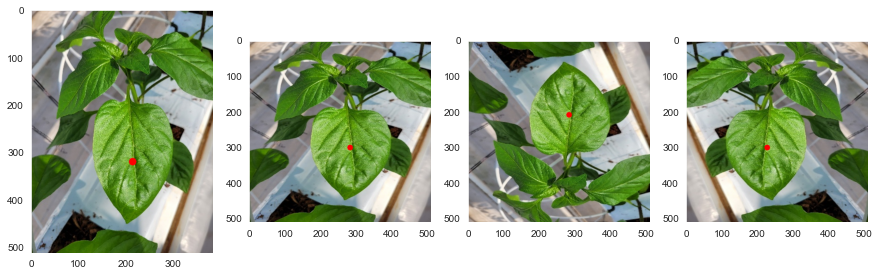

In [21]:
# f, ax = plt.subplots(1,4, figsize=(15,15))

# for i in range(1):
#     i= 3   
#     temp = imgs[i]
#     temp_img = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
#     x,y,w,h = objects[i][0],objects[i][1],objects[i][2],objects[i][3]
#     xc,yc = x+w//2,h//2+y
#     cv2.line(temp_img, (xc,yc), (xc,yc),(255,0,0),15)
    
#     # resize
#     temp = resize_imgs[i]
#     temp_img1 = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
#     #x,y,w,h =  df_resize.x[i], df_resize.y[i], df_resize.w[i], df_resize.h[i]
#     xc,yc = df_resize.xc[i],  df_resize.yc[i]
#     cv2.line(temp_img1, (xc,yc), (xc,yc),(255,0,0),15)
    
#     temp = flip0_imgs[i]
#     temp_img2 = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
#     xc,yc = df_flip0.xc[i], df_flip0.yc[i]
#     cv2.line(temp_img2, (xc,yc), (xc,yc), (255,0,0),15)

#     temp = flip1_imgs[i]
#     temp_img3 = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
#     xc,yc = df_flip1.xc[i], df_flip1.yc[i]
#     cv2.line(temp_img3, (xc,yc), (xc,yc), (255,0,0),15)
    
# ax[0].imshow(temp_img)
# ax[1].imshow(temp_img1)
# ax[2].imshow(temp_img2)
# ax[3].imshow(temp_img3)
# plt.show()

# 5-fold split

In [22]:
df_flips = pd.concat([df_resize, df_flip0, df_flip1])
df_flips.reset_index(inplace=True, drop=True) 
# Create train and validation split.
# 작물_부위의 비율을 유지하여 나눔
Fold = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=SEED)
for n, (train_index, val_index) in enumerate(Fold.split(df_flips, df_flips['crop_area'])):
    df_flips.loc[val_index, 'fold'] = int(n)
df_flips['fold'] = df_flips['fold'].astype(int)
df_flips.to_csv('train_fold.csv', index=False)
df_flips

,image,crops,areas,diseases,risks,crop_area,disease_risk,xc,yc,w,h,fold
0,10027_resize,3,3,b7,1,3_3,b7_1,228,272,220,237,2
1,10037_resize,3,5,00,0,3_5,00_0,253,34,64,315,4
2,10043_resize,3,1,00,0,3_1,00_0,254,297,362,271,4
3,10045_resize,3,3,00,0,3_3,00_0,284,302,229,263,4
4,10063_resize,3,1,00,0,3_1,00_0,246,336,380,283,2
...,...,...,...,...,...,...,...,...,...,...,...,...
17296,67640_flip1,3,5,00,0,3_5,00_0,338,106,213,370,2
17297,67644_flip1,1,3,00,0,1_3,00_0,212,224,420,488,4
17298,67647_flip1,2,3,a5,2,2_3,a5_2,233,336,241,174,4
17299,67649_flip1,1,3,00,0,1_3,00_0,165,181,293,239,2


In [23]:
# 파일명으로 정렬
df_flips = df_flips.sort_values(by=['image'])
file_path = sorted(glob(TRAIN_PATH +'*/*_*.jpg'))
df_flips['file_path'] = file_path
df_flips.reset_index(inplace=True,drop=True)
df_flips

,image,crops,areas,diseases,risks,crop_area,disease_risk,xc,yc,w,h,fold,file_path
0,10027_flip0,3,3,b7,1,3_3,b7_1,228,240,220,237,1,C:/git/jonie_github/VISION/_data/train\10027\1...
1,10027_flip1,3,3,b7,1,3_3,b7_1,284,272,220,237,2,C:/git/jonie_github/VISION/_data/train\10027\1...
2,10027_resize,3,3,b7,1,3_3,b7_1,228,272,220,237,2,C:/git/jonie_github/VISION/_data/train\10027\1...
3,10037_flip0,3,5,00,0,3_5,00_0,253,478,64,315,4,C:/git/jonie_github/VISION/_data/train\10037\1...
4,10037_flip1,3,5,00,0,3_5,00_0,259,34,64,315,0,C:/git/jonie_github/VISION/_data/train\10037\1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17296,67649_flip1,1,3,00,0,1_3,00_0,165,181,293,239,2,C:/git/jonie_github/VISION/_data/train\67649\6...
17297,67649_resize,1,3,00,0,1_3,00_0,347,181,293,239,3,C:/git/jonie_github/VISION/_data/train\67649\6...
17298,67678_flip0,5,3,b6,1,5_3,b6_1,272,349,245,424,4,C:/git/jonie_github/VISION/_data/train\67678\6...
17299,67678_flip1,5,3,b6,1,5_3,b6_1,240,163,245,424,2,C:/git/jonie_github/VISION/_data/train\67678\6...


# copy images to 5-fold dir

In [24]:
TRAIN_MODE_LIST = ['CROP_AREA','DISEASE_RISK']

df_crop = pd.DataFrame({'image': df_flips.image, 'xc':df_flips.xc, 'yc': df_flips.yc, 'w':df_flips.w, 'h':df_flips.h, 'label':df_flips.crop_area,'fold':df_flips.fold, 'path':df_flips.file_path})
df_disease = pd.DataFrame({'image': df_flips.image, 'xc':df_flips.xc, 'yc': df_flips.yc, 'w':df_flips.w, 'h':df_flips.h, 'label':df_flips.disease_risk,'fold':df_flips.fold,'path':df_flips.file_path})

In [25]:
if USE_FOLD:
    pass
else:
    # Remove existing dirs
    for mode in TRAIN_MODE_LIST:
        for fold in range(NUM_FOLD):
            print(f'{"="*30} CREATE [{mode}] {NUM_FOLD}-FOLD DATA SETS (IMAGE) FOLD_{fold} {"="*30}')

            TRAIN_MODE = mode
            if TRAIN_MODE=='CROP_AREA':
                df = df_crop.copy()
            elif TRAIN_MODE =='DISEASE_RISK':
                df = df_disease.copy()
            # Prepare train and valid df
            train_df = df.loc[df.fold != fold].reset_index(drop=True)
            valid_df = df.loc[df.fold == fold].reset_index(drop=True)

            try:
                shutil.rmtree(f'{TRAIN_MODE}/dataset_folds_{fold}/images')
                shutil.rmtree(f'{TRAIN_MODE}/dataset_folds_{fold}/labels')
            except:
                print('No dirs')

            # Make new dirs
            os.makedirs(f'{TRAIN_MODE}/dataset_folds_{fold}/images/train', exist_ok=True)
            os.makedirs(f'{TRAIN_MODE}/dataset_folds_{fold}/images/valid', exist_ok=True)
            os.makedirs(f'{TRAIN_MODE}/dataset_folds_{fold}/labels/train', exist_ok=True)
            os.makedirs(f'{TRAIN_MODE}/dataset_folds_{fold}/labels/valid', exist_ok=True)

            # Move the images to relevant split folder.
            for i in tqdm(range(len(train_df))):
                row = train_df.loc[i]
                copyfile(row.path, f'{TRAIN_MODE}/dataset_folds_{fold}/images/train/{row.image}.jpg')

            for i in tqdm(range(len(valid_df))):
                row = train_df.loc[i]
                copyfile(row.path, f'{TRAIN_MODE}/dataset_folds_{fold}/images/valid/{row.image}.jpg')

============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (IMAGE) FOLD_0 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3461/3461 [00:05<00:00, 669.59it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (IMAGE) FOLD_1 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 675.72it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (IMAGE) FOLD_2 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:04<00:00, 728.82it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (IMAGE) FOLD_3 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 655.54it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (IMAGE) FOLD_4 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 620.12it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (IMAGE) FOLD_0 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3461/3461 [00:05<00:00, 679.68it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (IMAGE) FOLD_1 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 604.97it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (IMAGE) FOLD_2 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 674.73it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (IMAGE) FOLD_3 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 622.91it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (IMAGE) FOLD_4 ==============================
No dirs


100%|█████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:05<00:00, 672.59it/s]


# 5. create label & bbox

In [33]:
def get_yolo_format_bbox(row):
    # yolo format bbox
    xc = row.xc/IMG_SIZE
    yc = row.yc/IMG_SIZE
    w = row.w/IMG_SIZE
    h = row.h/IMG_SIZE
    if (xc*yc*w*h<0) | ((xc>1) | (yc>1) | (w>1) | (h>1)) :
        raise Exception('Please check the bbox coordinates.')
    
    return [str(xc), str(yc), str(w), str(h)]

In [28]:
def write_bbox_files(tmp_df, fold_num, split):
    path = f'{TRAIN_MODE}/dataset_folds_{fold}/labels/{split}'
    
    for i in tqdm(range(len(tmp_df))):
        row = tmp_df.loc[i]

        # Get image name
        img_name = row.image
        
        # Get  label
        if TRAIN_MODE=='CROP_AREA':
            le = crop_le
        elif TRAIN_MODE=='DISEASE_RISK':
            le = disease_le
        label = le.transform([row.label])[0]
        
        bbox_str = ' '.join(get_yolo_format_bbox(row))
        
        file_name = f'{path}/{img_name}.txt'

        with open(file_name, 'w') as f:
            f.write(str(label) + ' ' + bbox_str + '\n')             

In [29]:
crop_le = LabelEncoder()
disease_le = LabelEncoder()

crop_le.fit(df_crop['label'])
disease_le.fit(df_disease['label'])

if USE_FOLD:
    pass
else:
    # Prepare the txt files for bounding box
    for mode in TRAIN_MODE_LIST:
        for fold in range(NUM_FOLD):
            print(f'{"="*30} CREATE [{mode}] {NUM_FOLD}-FOLD DATA SETS (ANNOTATION) FOLD_{fold} {"="*30}')

            TRAIN_MODE = mode
            if TRAIN_MODE=='CROP_AREA':
                df = df_crop.copy()
                
            elif TRAIN_MODE =='DISEASE_RISK':
                df = df_disease.copy()

            # Prepare train and valid df
            train_df = df.loc[df.fold != fold].reset_index(drop=True)
            valid_df = df.loc[df.fold == fold].reset_index(drop=True)

            # prepare label for train
            write_bbox_files(train_df, fold, 'train')
            # prepare label for valid
            write_bbox_files(valid_df, fold, 'valid')

============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (ANNOTATION) FOLD_0 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3461/3461 [00:02<00:00, 1369.08it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (ANNOTATION) FOLD_1 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1382.09it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (ANNOTATION) FOLD_2 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1376.93it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (ANNOTATION) FOLD_3 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1283.39it/s]


============================== CREATE [CROP_AREA] 5-FOLD DATA SETS (ANNOTATION) FOLD_4 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1376.68it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (ANNOTATION) FOLD_0 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3461/3461 [00:02<00:00, 1405.89it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (ANNOTATION) FOLD_1 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1400.45it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (ANNOTATION) FOLD_2 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1347.06it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (ANNOTATION) FOLD_3 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1258.50it/s]


============================== CREATE [DISEASE_RISK] 5-FOLD DATA SETS (ANNOTATION) FOLD_4 ==============================


100%|████████████████████████████████████████████████████████████████████████████| 3460/3460 [00:02<00:00, 1389.12it/s]


# 6.creat `.yaml` files

In [50]:
print(len(df_crop.label.unique()))
print(len(df_disease.label.unique()))

16
17


In [56]:
# Create .yaml file 
import yaml
for mode in TRAIN_MODE_LIST:
    TRAIN_MODE = mode
    if TRAIN_MODE=='CROP_AREA':
        label_unique = len(df_crop.label.unique())
    elif TRAIN_MODE =='DISEASE_RISK':
        label_unique = len(df_disease.label.unique())

    for fold in range(NUM_FOLD):
        data_yaml = dict(
                path = f'../{mode}/dataset_folds_{fold}/images',
                train = 'train',
                val = 'valid',
                nc = label_unique,
                names = [i for i in range(label_unique)]
          )

        with open(f'yolov5/data/{mode}_data_fold_{fold}.yaml', 'w') as outfile:
            yaml.dump(data_yaml, outfile, default_flow_style=True)

# 7. 5-fold training with W&B

In [57]:
%cd yolov5

C:\git\jonie_github\VISION\yolov5


In [53]:
import wandb
wandb.login()

wandb: Currently logged in as: jonikwon (use `wandb login --relogin` to force relogin)


True

- --img {IMG_SIZE} \ # Input image size.
- --batch {BATCH_SIZE} \ # Batch size
- --epochs {EPOCHS} \ # Number of epochs
- --data data.yaml \ # Configuration file
- --weights yolov5s.pt \ # Model name
- --save-period 1\ # Save model after interval
- --project crop-disease-pjt # W&B project name

# TEST (EPOCH1)

In [ ]:
# TEST MODE 1 EPOCHS 1
yolo_weight = 'yolov5l'
TRAIN_MODE = TRAIN_MODE_LIST[0]
for fold in range(NUM_FOLD):    
    print('FOLD NUMBER: ', fold)
    !python train.py --img {IMG_SIZE} \
                     --batch {BATCH_SIZE} \
                     --epochs {1} \
                     --data {TRAIN_MODE}_data_fold_{fold}.yaml \
                     --weights {yolo_weight}.pt \
                     --save-period 10\
                     --project {yolo_weight}-{TRAIN_MODE}-fold-{fold}\
                     --name {yolo_weight}-e-{1}-img-{IMG_SIZE}-fold-{fold}
    print('###########################################################################################\n')

FOLD NUMBER:  0


In [ ]:
yolo_weight = 'yolov5l'
for mode in TRAIN_MODE_LIST:
    TRAIN_MODE = mode
    for fold in range(NUM_FOLD):    
        print('FOLD NUMBER: ', fold)
        !python train.py --img {IMG_SIZE} \
                         --batch {BATCH_SIZE} \
                         --epochs {EPOCHS} \
                         --data {TRAIN_MODE}_data_fold_{fold}.yaml \
                         --weights {yolo_weight}.pt \
                         --save-period 10\
                         --project {yolo_weight}-{TRAIN_MODE}-fold-{fold}\
                         --name {yolo_weight}-e-{EPOCHS}-img-{IMG_SIZE}-fold-{fold}
        print('###########################################################################################\n')

# csv 데이터 확인

In [ ]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

min_dict = {x:x+'_min' for x in csv_features}
max_dict = {x:x+'_max' for x in csv_features}

In [ ]:
for i, d in enumerate(train_csv):
    _min = pd.read_csv(d)[csv_features].min(axis=0)
    _max = pd.read_csv(d)[csv_features].max(axis=0)
    _min.rename(min_dict, axis=1, inplace=True)
    _max.rename(max_dict, axis=1, inplace=True)
    data.loc[i,list(min_dict.values())] = _min
    data.loc[i,list(max_dict.values())] = _max

# 해볼것. 
### 1. cutmix, 블러 이미지 생성
### 2. csv 정보사용
### 3. pretrain data + aihub데이터